In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime
import plotly.express as px
import numpy as np

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
%cd /content/drive/Shareddrives/Data606_Energy/data/futures

/content/drive/Shareddrives/Data606_Energy/data/futures


In [6]:
data = pd.read_csv('futures_data.csv')

In [7]:
# convert the date column into datetime index
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

In [8]:
# here I am creating a standardized data set that it standardized based on rolling means and rolling standard deviations
# the reason for doing this is that for many of these contracts, the average volume increases as time goes on. However, we want to
# know about the impact of volume that is above or below the normal ammount
data_standardized = data.copy()
period = 6#period = 21
for col in data.columns:
  # standardize the columns which have monthly average to be (avg - rollinging avg)/(rolling std)
  if 'Mean' in col:
    # how the mean of each month/year compare to the means of the last "period" number of months in comparison to the last "period" of months' standard deviations in the underlying column (either price movement or volume)
    # create a column that is the average for that (month - moving average of monthly averages)/(moving average of monthly standard deviations)
    data_standardized[col+' Standardized'] = (data_standardized[col] - data_standardized[col].rolling(period).mean())/data_standardized[col.replace('Mean','Std')].rolling(period).mean()
  # standardize the columns which have monthly standard deviation to be (std - rolling mean of std)/(rolling std)
  if 'Std' in col:
    # how the standard deviation compare to the previous "period" number of months - is the variation in the underlying data (either price movement or volume) higher or lower than expected
    data_standardized[col+' Standardized'] = (data_standardized[col]-data_standardized[col].rolling(period).mean())/data_standardized[col].rolling(period).std()

In [9]:
# I also want to include some variables for the coefficient of variances
for ticker in ['BZ=F','NG=F','CL=F','HO=F']:
  # one set where the CV is for each month
  data_standardized['CV Movement '+ticker] = data_standardized['Std Movement Daily '+ticker]/data_standardized['Mean Movement Daily '+ticker]
  data_standardized['CV Volume '+ticker] = data_standardized['Std Volume Daily '+ticker]/data_standardized['Mean Volume Daily '+ticker]
  # another set where the CV is for the rolling values from the past  "period" number of months
  data_standardized['CV Movement Rolling '+ticker] = data_standardized['Std Movement Daily '+ticker].rolling(period).std()/data_standardized['Mean Movement Daily '+ticker].rolling(period).mean()
  data_standardized['CV Volume Rolling '+ticker] = data_standardized['Std Volume Daily '+ticker].rolling(period).std()/data_standardized['Mean Volume Daily '+ticker].rolling(period).mean()
  # now create binary variables for whether the months mean price movement or volume are above the average from the past "period" number of months
  data_standardized['Movement Above Average '+ticker] = (data_standardized['Mean Movement Daily '+ticker] - data_standardized['Mean Movement Daily '+ticker].rolling(period).mean()) > 0
  data_standardized['Volume Above Average '+ticker] = (data_standardized['Mean Volume Daily '+ticker] - data_standardized['Mean Volume Daily '+ticker].rolling(period).mean()) > 0

### Look at some correlations

In [10]:
print("Correlations between standardized volume and standardized price movement\n")
print(data_standardized[['Mean Movement Daily BZ=F Standardized','Mean Volume Daily BZ=F Standardized']].corr())
print("\nCorrelations between standardized volume standard deviations and standardized price movement standard deviations\n")
print(data_standardized[['Std Movement Daily BZ=F Standardized','Std Volume Daily BZ=F Standardized']].corr())
print("\nCorrelations between standarduzed mean daily volume and standardized standard deviation in daily volume\n")
print(data_standardized[['Mean Volume Daily BZ=F Standardized','Std Movement Daily BZ=F Standardized']].corr())
print("\nCorrelations betwee standardized standard deviation in daily volume and standardized mean daily price movement\n")
print(data_standardized[['Std Volume Daily BZ=F Standardized','Mean Movement Daily BZ=F Standardized']].corr())
print('\nCorrelations between the coefficient of variances.\n')
print(data_standardized[['CV Movement BZ=F','CV Volume BZ=F']].corr())
print(data_standardized[['CV Movement Rolling BZ=F','CV Volume Rolling BZ=F']].corr())
print('\nCorrelations between the binary variables\n')
print(data_standardized[['Movement Above Average BZ=F','Volume Above Average BZ=F']].corr())

Correlations between standardized volume and standardized price movement

                                       Mean Movement Daily BZ=F Standardized  Mean Volume Daily BZ=F Standardized
Mean Movement Daily BZ=F Standardized                               1.000000                             0.295376
Mean Volume Daily BZ=F Standardized                                 0.295376                             1.000000

Correlations between standardized volume standard deviations and standardized price movement standard deviations

                                      Std Movement Daily BZ=F Standardized  Std Volume Daily BZ=F Standardized
Std Movement Daily BZ=F Standardized                               1.00000                             0.29757
Std Volume Daily BZ=F Standardized                                 0.29757                             1.00000

Correlations between standarduzed mean daily volume and standardized standard deviation in daily volume

                              

## Now to show some of the higher correlations in scatterplots

In [11]:
# ticker = 'BZ=F'
# condition = (daily_combined['Tickers']==ticker) & (daily_combined.index>=datetime(year=2015,month=1,day=1))
# fig = px.scatter(x=daily_combined['Mean Volume Daily'][condition], y=daily_combined['Mean Movement Daily'][condition], 
#                  hover_data=[list(daily_combined.index[condition].strftime('%Y-%m-%d'))], width=800, height=600, 
#                  title = "Impact of Volume of Futures Contracts Traded\nOn Price Volatility",
#                  labels = {'x':'Mean Daily Volume per  Month',
#                            'y':'Mean Daily Price Movement per Month (%)'})
# fig.show()

(0.0, 1.0)

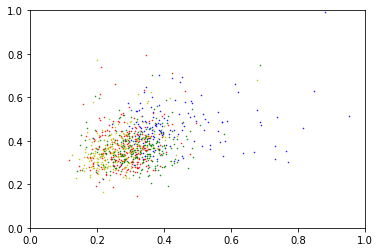

In [12]:
plt.scatter(data_standardized['CV Volume BZ=F'],data_standardized['CV Movement BZ=F'],c='b',s=0.25)
plt.scatter(data_standardized['CV Volume NG=F'],data_standardized['CV Movement NG=F'],c='r',s=0.25)
plt.scatter(data_standardized['CV Volume CL=F'],data_standardized['CV Movement CL=F'],c='y',s=0.25)
plt.scatter(data_standardized['CV Volume HO=F'],data_standardized['CV Movement HO=F'],c='g',s=0.25)
plt.xlim(0,1)
plt.ylim(0,1)

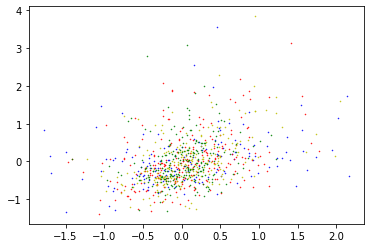

In [13]:
plt.scatter(data_standardized['Mean Volume Daily BZ=F Standardized'],data_standardized['Mean Movement Daily BZ=F Standardized'],c='b',s=0.25)
plt.scatter(data_standardized['Mean Volume Daily NG=F Standardized'],data_standardized['Mean Movement Daily NG=F Standardized'],c='r',s=0.25)
plt.scatter(data_standardized['Mean Volume Daily CL=F Standardized'],data_standardized['Mean Movement Daily CL=F Standardized'],c='y',s=0.25)
plt.scatter(data_standardized['Mean Volume Daily HO=F Standardized'],data_standardized['Mean Movement Daily HO=F Standardized'],c='g',s=0.25)

This plot above looks pretty nice

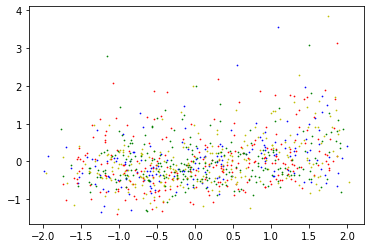

In [14]:
plt.scatter(data_standardized['Std Volume Daily BZ=F Standardized'],data_standardized['Mean Movement Daily BZ=F Standardized'],c='b',s=0.5)
plt.scatter(data_standardized['Std Volume Daily NG=F Standardized'],data_standardized['Mean Movement Daily NG=F Standardized'],c='r',s=0.5)
plt.scatter(data_standardized['Std Volume Daily CL=F Standardized'],data_standardized['Mean Movement Daily CL=F Standardized'],c='y',s=0.5)
plt.scatter(data_standardized['Std Volume Daily HO=F Standardized'],data_standardized['Mean Movement Daily HO=F Standardized'],c='g',s=0.5)

The stuff in the plot above seems too flat

## Now to explore using the binary variables

In [15]:
one_one = data_standardized['Movement Above Average BZ=F'] & data_standardized['Volume Above Average BZ=F']
zero_zero = ~data_standardized['Movement Above Average BZ=F'] & ~data_standardized['Volume Above Average BZ=F']
one_zero = data_standardized['Movement Above Average BZ=F'] & ~data_standardized['Volume Above Average BZ=F']
zero_one = ~data_standardized['Movement Above Average BZ=F'] & data_standardized['Volume Above Average BZ=F']
print(np.array([[zero_zero.sum(),zero_one.sum()],
               [one_zero.sum(),one_one.sum()]]))

[[155  31]
 [ 26  52]]


In [16]:
print("There are {} months where mean price movement was above average".format(data_standardized['Movement Above Average BZ=F'].sum()))
print("There are {} months where mean Movement movement was below average".format(data_standardized.shape[0] - data_standardized['Movement Above Average BZ=F'].sum()))

There are 78 months where mean price movement was above average
There are 186 months where mean Movement movement was below average


This means that of the times when price movement for a month is higher than average, ~66% of these months also had above average volume. Of the times when price movement for a month is lower than average, ~83% of these months also had below average volume.

# Deciding what to keep from the data and save it

In [17]:
to_keep = ['Date']
for ticker in ['BZ=F','NG=F','CL=F','HO=F']:
  # keep the standardized mean volume daily and the mean movement daily
  to_keep.append('Mean Volume Daily '+ticker+' Standardized')
  to_keep.append('Mean Movement Daily '+ticker+' Standardized')
  # keep the binary above average movement and volume columns
  to_keep.append('Movement Above Average '+ticker)
  to_keep.append('Volume Above Average '+ticker)

In [18]:
to_save = data_standardized.copy()[to_keep]

In [ ]:
#to_save.to_csv('futures_data_merge_read.csv')

In [30]:
# since we are doing the annual level now, I will keep the above code for aggregating at the monthly level in case I need it again
# but for annual I will just take the total # of months with above average price movement and above average volume
annual_summary = pd.DataFrame({'Year':pd.DatetimeIndex(to_save['Date']).year.unique()})
for ticker in ['BZ=F','NG=F','CL=F','HO=F']:
  months_above_average_movement, months_above_average_volume = [],[]
  for y in pd.DatetimeIndex(to_save['Date']).year.unique():
    months_above_average_movement.append(to_save['Movement Above Average '+ticker][pd.DatetimeIndex(to_save['Date']).year==y].sum())
    months_above_average_volume.append(to_save['Volume Above Average '+ticker][pd.DatetimeIndex(to_save['Date']).year==y].sum())
  annual_summary['Months Above Average Price Movement '+ticker] = months_above_average_movement
  annual_summary['Months Above Average Price Volume '+ticker] = months_above_average_volume

In [34]:
annual_summary.to_csv('annual_futures_summary.csv')